# Gradient Descent
---

In [101]:
%pip install torch sympy numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Manual Differentiation

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Iterable
%matplotlib inline

In [103]:
def f_x(x): return x**3 - 4*x**2 + 6
def df_dx(x): return 3*x**2 - 8*x

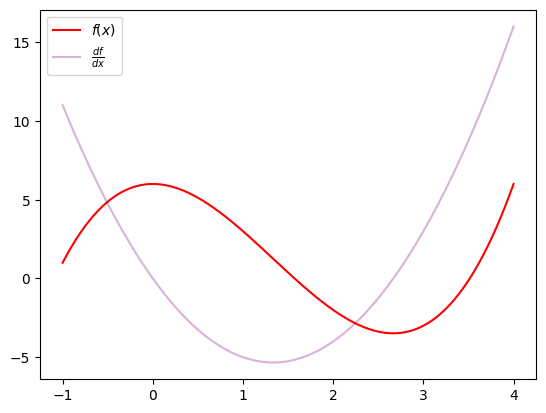

In [104]:
x = np.linspace(-1, 4, 10000)
plt.plot(x, f_x(x), color="red", label="$f(x)$")
plt.plot(x, df_dx(x), color="purple", label=r"$\frac{df}{dx}$", alpha=0.3)
plt.legend()
plt.show()

Wherever ∇f(x) < 0, the function is decreasing. When ∇f(x) > 0 the function is increasing. We want to move in the direction opposite the gradient.

In [105]:
def gradient_descent(x0: float, bounds: Iterable, step_size: float, max_iter: int, eps: float) -> Tuple[np.ndarray, np.ndarray]:
    x_history = [x0]
    y_history = [f_x(x0)]

    for i in range(0, max_iter):
        x_t = x_history[i] - (step_size * df_dx(x_history[i]))
        x_t = min(max(bounds[0], x_t), bounds[1]) # Ensures that no movement occurs outside of the function bounds
        y_t = f_x(x_t)

        x_history.append(x_t)
        y_history.append(y_t)

        print(f"Iteration: {i+1}")
        print(f"Current local minimum: {x_t}")
        print(f"Function eval: {y_t}")
        print("-"*30)

        if eps:
            if np.abs(x_t - x_history[i]) < eps:
                break

    return x_history, y_history

bounds = [min(x), max(x)]
x_hist, y_hist = gradient_descent(x0=0.5, bounds=bounds, step_size=0.05, max_iter=100, eps=0.001)

Iteration: 1
Current local minimum: 0.6625
Function eval: 4.535150390625
------------------------------
Iteration: 2
Current local minimum: 0.8616640625
Function eval: 3.6698955443552763
------------------------------
Iteration: 3
Current local minimum: 1.0949599440093996
Function eval: 2.517039179928002
------------------------------
Iteration: 4
Current local minimum: 1.3531033297653994
Function eval: 1.1538270054458906
------------------------------
Iteration: 5
Current local minimum: 1.6197113685182276
Function eval: -0.24460371775757128
------------------------------
Iteration: 6
Current local minimum: 1.8740761783294402
Function eval: -1.4665878455611931
------------------------------
Iteration: 7
Current local minimum: 2.0968824213339343
Function eval: -2.367847920080319
------------------------------
Iteration: 8
Current local minimum: 2.2760980065326186
Function eval: -2.9308848265169036
------------------------------
Iteration: 9
Current local minimum: 2.409443888844402
Funct

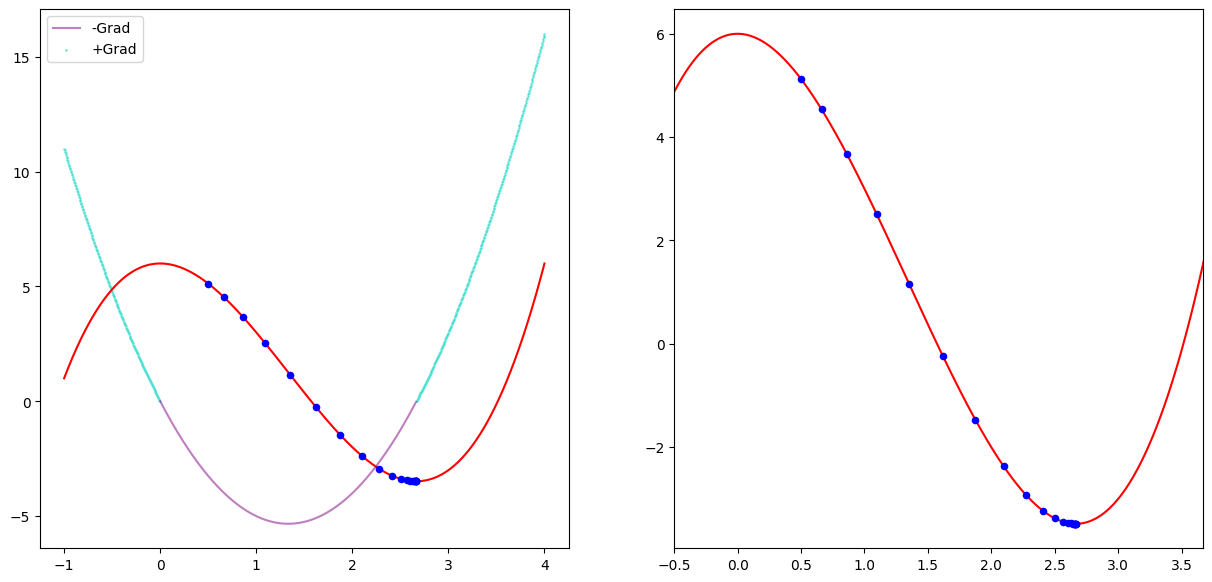

In [106]:
fig = plt.figure(figsize=(15,7))
x = np.linspace(-1, 4, 1000)
y = list(map(f_x, x))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# Base plot
ax1.plot(x, y, color="red")
y_diff = np.array(list(map(df_dx, x)))
neg_grad = y_diff[y_diff < 0]
pos_grad = y_diff[y_diff > 0]

ax1.plot(x[y_diff < 0], neg_grad, color="purple", label="-Grad", alpha=0.5)
ax1.scatter(x[y_diff > 0], pos_grad, color="turquoise", s=0.75, label="+Grad", alpha=0.7)
ax1.scatter(x_hist, y_hist, color="blue", s=20, zorder=2)

ax2.set_xlim([np.min(x_hist)-1, np.max(x_hist)+1])
ax2.plot(x, y, color="red")
ax2.scatter(x_hist, y_hist, color="blue", s=20, zorder=2)
ax1.legend()
plt.show()

# 2. Symbolic Differentiation

Finding the partial derivatives by hand can be tedious and is the option most prone to error. A slightly better way to do this and with less on our part is by **symbolic differentiation**. If you have every used a tool like symbolab to compute integrals/derivatives this is similar.

In [107]:
from sympy import symbols, lambdify
x1, x2 = symbols('x1 x2')
f_x = x2**3 + x1**2 + x1*x2 + 1
f_x

x1**2 + x1*x2 + x2**3 + 1

In [108]:
f_x.diff(x1)

2*x1 + x2

In [109]:
from sympy.tensor.array import derive_by_array

grad = derive_by_array(f_x, (x1, x2))
grad

[2*x1 + x2, x1 + 3*x2**2]

In [110]:
f_x_lambda = lambdify([x1, x2], f_x, "numpy") # The function
grad_f = [lambdify([x1, x2], f, "numpy") for f in grad] # The gradient of the function w.r.t. each variable

In [111]:
x0 = np.array([2, 10])
display(grad[0])
grad_f[0](*x0)

2*x1 + x2

14

In [112]:
f_x_lambda(*x0)

1025

In [113]:
def gradient_descent(x0: float, bounds: Iterable, step_size: float, max_iter: int, eps: float) -> Tuple[np.ndarray, np.ndarray]:
    x_history = [x0]
    y_history = [f_x_lambda(*x0)]

    for i in range(max_iter):
        x_t = np.array([0., 0.])
        for j in range(len(x0)):
            x_t[j] = x_history[i][j] - (step_size * grad_f[j](*x_history[i])) # Update parameter j
            x_t[j] = min(max(bounds[j][0], x_t[j]), bounds[j][1]) # Ensures that no movement occurs outside of the function bounds

        y_t = f_x_lambda(*x_t)

        x_history.append(x_t)
        y_history.append(y_t)

        print(f"Iteration: {i+1}")
        print(f"Current local minimum: {x_t}")
        print(f"Function eval: {y_t}")
        print("-"*30)

        if eps:
            if np.abs(x_t - x_history[i]).sum() < eps:
                break

    return x_history, y_history


x0 = np.array([2, 10])
bounds = [(-np.inf, np.inf) for _ in range(2)]
hist = gradient_descent(x0=x0, bounds=bounds, step_size=0.01, max_iter=100, eps=0.001)

Iteration: 1
Current local minimum: [1.86 6.98]
Function eval: 357.5107920000001
------------------------------
Iteration: 2
Current local minimum: [1.753    5.499788]
Function eval: 180.06989910556652
------------------------------
Iteration: 3
Current local minimum: [1.66294212 4.57482796]
Function eval: 107.11985758105766
------------------------------
Iteration: 4
Current local minimum: [1.583935   3.93032701]
Function eval: 70.44784284548437
------------------------------
Iteration: 5
Current local minimum: [1.51295303 3.45106355]
Function eval: 49.61193730695108
------------------------------
Iteration: 6
Current local minimum: [1.44818333 3.07863883]
Function eval: 36.735059720954254
------------------------------
Iteration: 7
Current local minimum: [1.38843328 2.77981649]
Function eval: 28.268034140573906
------------------------------
Iteration: 8
Current local minimum: [1.33286645 2.53411076]
Function eval: 22.427507229394543
------------------------------
Iteration: 9
Curren

# 3. Autograd

Collection of approaches where gradient computation is done automatically through a computation graph.

## 3.1 Pytorch
---
**Step 1: Create a computation graph**

When you create a PyTorch tensor and provide the argument `requires_grad=True`, it is automatically attached to a computation graph.

**Step 2: Perform forward pass**

When you perform operations on tensors, such as matrix multiplication or convolution, PyTorch creates a new tensor that represents the result of those operations. The computation graph is updated to reflect the new operations.

**Step 3: Compute gradients**

When you call the `backward()` method on a tensor, PyTorch traverses the computation graph in reverse order, computing the gradients of each operation with respect to its inputs. This is done using the chain rule of calculus.

**Step 4: Accumulate gradients**

As PyTorch computes the gradients, it accumulates them in the `grad` attribute of each tensor. This allows you to access the gradients of each tensor after the backward pass.

**Step 5: Update model parameters**

Using the accumulated gradients, you can update the model parameters using an optimization algorithm, such as stochastic gradient descent (SGD).

In summary, PyTorch's Autograd system automatically creates a computation graph, performs forward and backward passes, computes gradients, accumulates them, and allows you to update model parameters using optimization algorithms

### 3.1.1 Neural Network Example

In [114]:
import torch
import torch.nn.functional as F
import torch.nn as nn

torch.manual_seed(192)

batch_X = torch.rand((20, 100))
batch_Y = torch.rand((20, ))
W = torch.rand((30, 100), requires_grad=True) # Requires grad indicates ~where~ the gradient needs to be propogated to
b = torch.rand((30,), requires_grad=True)

activations = F.relu(torch.sum(batch_X @ W.T + b, axis=1))
activations

tensor([800.9057, 820.4493, 748.7545, 846.4409, 768.4225, 879.1286, 712.5182,
        707.7337, 803.5945, 749.7166, 758.0955, 773.0328, 806.3203, 765.3997,
        720.9338, 754.8772, 827.6507, 763.8168, 700.7144, 755.8879],
       grad_fn=<ReluBackward0>)

In [115]:
loss = nn.MSELoss()(batch_Y, activations)
loss.backward() # Propogate the gradient backwards through the computation graph

In [116]:
print(f"{W.grad=}\n{b.grad=}")

W.grad=tensor([[701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976],
        [701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976],
        [701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976],
        ...,
        [701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976],
        [701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976],
        [701.6978, 764.7663, 817.0551,  ..., 724.7969, 803.5891, 549.8976]])
b.grad=tensor([1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539,
        1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539,
        1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539,
        1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539,
        1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539, 1545.4539])


### 3.1.2 Classical Example

In [117]:
x = torch.rand((20,), requires_grad=True)

def torch_f(x): return (torch.sin(x) + torch.cos(x)**6 + 1/1+torch.exp(x)).mean()

y = torch_f(x)
y.backward()

(x.detach() - x.grad) # Detach removes a tensor from the computation graph

tensor([ 0.3848,  0.6649,  0.8092,  0.4758,  0.5127,  0.0332,  0.4222,  0.3086,
         0.1175,  0.1416,  0.5215,  0.7625,  0.2948,  0.7819, -0.0881,  0.5417,
         0.8413,  0.3546,  0.7818,  0.8437])

In [118]:
def gradient_descent(x0: float, step_size: float, max_iter: int, eps: float) -> Tuple[np.ndarray, np.ndarray]:
    x_history = [x0]

    with torch.no_grad():
        y_history = [torch_f(x)]

    for i in range(max_iter):
        y_t = torch_f(x_history[i])

        y_t.backward() # Compute gradient backwards through computational graph

        x_t = x_history[i].detach().clone() - step_size*x_history[i].grad
        x_t.requires_grad = True
        x_history[i].requires_grad = False # No longer need the gradient stored in parameters from t-1 step

        x_history.append(x_t)
        y_history.append(y_t.item())

        print(f"Iteration: {i+1}")
        print(f"Current local minimum: {x_t}")
        print(f"Function eval: {y_t.item()}")
        print("-"*30)
        
        if eps:
            # Or torch.inference_mode(), basically don't attach anything in here to the computation graph
            with torch.no_grad(): 
                dx = torch.abs(x_t - x_history[i]).sum()
                if dx < eps:
                    break

    return x_history, y_history

torch.manual_seed(0)
x0 = torch.rand((20,), requires_grad=True)

history = gradient_descent(x0, step_size=0.05, max_iter=1000, eps=0.001)

Iteration: 1
Current local minimum: tensor([0.4937, 0.7630, 0.0846, 0.1286, 0.3052, 0.6304, 0.4876, 0.8899, 0.4533,
        0.6286, 0.3468, 0.3996, 0.0176, 0.1658, 0.2916, 0.5158, 0.6933, 0.7945,
        0.1579, 0.2800], requires_grad=True)
Function eval: 3.554438829421997
------------------------------
Iteration: 2
Current local minimum: tensor([0.4912, 0.7579, 0.0806, 0.1251, 0.3030, 0.6267, 0.4851, 0.8834, 0.4510,
        0.6250, 0.3446, 0.3974, 0.0128, 0.1627, 0.2894, 0.5131, 0.6889, 0.7890,
        0.1547, 0.2777], requires_grad=True)
Function eval: 3.549118757247925
------------------------------
Iteration: 3
Current local minimum: tensor([0.4887, 0.7528, 0.0766, 0.1216, 0.3008, 0.6231, 0.4826, 0.8769, 0.4487,
        0.6213, 0.3425, 0.3952, 0.0080, 0.1595, 0.2871, 0.5105, 0.6846, 0.7836,
        0.1515, 0.2753], requires_grad=True)
Function eval: 3.543834686279297
------------------------------
Iteration: 4
Current local minimum: tensor([0.4862, 0.7478, 0.0725, 0.1180, 0.2985, 0

Iteration: 59
Current local minimum: tensor([ 0.3626,  0.5406, -0.2437, -0.1584,  0.1550,  0.4620,  0.3574,  0.6092,
         0.3270,  0.4608,  0.2112,  0.2731, -0.3633, -0.0855,  0.1350,  0.3806,
         0.5007,  0.5580, -0.1009,  0.1172], requires_grad=True)
Function eval: 3.2301697731018066
------------------------------
Iteration: 60
Current local minimum: tensor([ 0.3605,  0.5378, -0.2512, -0.1652,  0.1517,  0.4596,  0.3553,  0.6058,
         0.3248,  0.4585,  0.2085,  0.2708, -0.3712, -0.0916,  0.1316,  0.3785,
         0.4981,  0.5550, -0.1071,  0.1136], requires_grad=True)
Function eval: 3.223159074783325
------------------------------
Iteration: 61
Current local minimum: tensor([ 0.3583,  0.5349, -0.2587, -0.1721,  0.1485,  0.4573,  0.3532,  0.6024,
         0.3226,  0.4561,  0.2058,  0.2684, -0.3791, -0.0977,  0.1281,  0.3764,
         0.4955,  0.5520, -0.1134,  0.1099], requires_grad=True)
Function eval: 3.216078281402588
------------------------------
Iteration: 62
Current